In [ ]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128

Looking in indexes: https://download.pytorch.org/whl/cu128


In [ ]:
!pip3 install matplotlib scikit-learn seaborn

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Use device: {device}")

Use device: cuda


In [9]:
root_directory = "/content/drive/MyDrive/Colab Notebooks/pizza_classifier/"

In [5]:

# Định nghĩa transformation để huấn luyện model
# Giúp cho việc nhận diện hình ảnh trong nhiều trường hợp hơn. Bằng cách
#   - Cắt ảnh nhỏ hơn để kiểm nhận ra
#   - Lật ảnh
#   - Xoay ảnh
#   - Ảnh có ánh sáng ±1, tương phản ±1, xoay ảnh ±10°
#   - Đổi góc nhìn ảnh bằng Affine
#   - Đổi góc nhìn ảnh bằng Perspective
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Cắt ngẫu nhiên và resize
    transforms.RandomHorizontalFlip(),  # Lật ngang ngẫu nhiên
    # transforms.RandomRotation(10),      # Xoay ngẫu nhiên
    transforms.ColorJitter(
        brightness=0.1,                 # Thay đổi độ sáng 10%
        contrast=0.1,                   # Thay đổi độ tương phản 10%
        saturation=0.1,                 # Thay đổi độ bão hoà 10%
        hue=0.05
    ),
    # Choose only one geometric transformation with 50% probability
    transforms.RandomApply([
        transforms.RandomChoice([
            transforms.RandomRotation(5),  # Reduced rotation angle
            transforms.RandomAffine(
                degrees=0,
                translate=(0.05, 0.05),    # Reduced translation
                scale=(0.95, 1.05)         # Reduced scaling
            ),
            transforms.RandomPerspective(
                distortion_scale=0.1,      # Reduced distortion
                p=0.5
            )
        ])
    ], p=0.5),
    # transforms.RandomAffine(            # Thay đổi góc ảnh bằng Affine
    #     degrees=0,
    #     translate=(0.1, 0.1),
    #     scale=(0.9, 1.1)
    # ),
    # transforms.RandomPerspective(       # Thay đổi góc ảnh bằng Perspective
    #     distortion_scale=0.2,
    #     p=0.5
    # ),
    transforms.ToTensor(),              # Chuyển ảnh thành dữ liệu cho Pytorch
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [6]:
# Định nghĩa transform để test
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [10]:
# Tạo dataset từ thư mục chứa hình ảnh
# Thư mục data với 2 thư mục con: pizza và not_pizza
data_directory = "data"
# Tạo dataset mới với data augmentation
train_dataset_aug = torchvision.datasets.ImageFolder(
    root=root_directory+data_directory,
    transform=transform_train
)

test_dataset_aug = torchvision.datasets.ImageFolder(
    root=root_directory+data_directory,
    transform=transform_test
)

In [11]:
# Lưu lại các tên dataset có trong thư mục data(pizza, not_pizza)
# data
# ├───not_pizza
# └───pizza
classes = train_dataset_aug.classes

In [12]:
# Chia dataset thành training set và test set
# Chia dataset
train_size = int(0.8 * len(train_dataset_aug))
test_size = len(train_dataset_aug) - train_size
train_dataset_aug, _ = torch.utils.data.random_split(train_dataset_aug, [train_size, test_size])
_, test_dataset_aug = torch.utils.data.random_split(test_dataset_aug, [train_size, test_size])

In [13]:
# Tạo DataLoader mới
batch_size = 64
train_loader_aug = torch.utils.data.DataLoader(
    train_dataset_aug,
    batch_size=batch_size,
    shuffle=True
)

test_loader_aug = torch.utils.data.DataLoader(
    test_dataset_aug,
    batch_size=batch_size,
    shuffle=False
)

In [ ]:

# Tạo một class PizzaClassifier để qua quá trình train
class PizzaClassifier(nn.Module):
    def __init__(self):
        super(PizzaClassifier, self).__init__()
        # Lớp tích chập đầu tiên
        # Đầu vào là ảnh có kích thước 224x224x3 (3 ở đây là channel mày RGB)
        # Đầu ra là ma trận có kích thước 224x224x32
        self.convolutional_1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        # Lớp gộp đầu tiên
        # Đầu vào là ma trận có kích thước 224x224x32 (từ lớp chập đầu tiên)
        # Đầu ra là ma trận có kích thước 112x112x32
        self.pooling_1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Lớp tích chập thứ hai
        # Đầu vào là ma trận có kích thước 112x112x32 (từ gộp đầu tiên)
        # Đầu ra là ma trận có kích thước 112x112x64
        self.convolutional_2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # Lớp gộp thứ hai
        # Đầu vào là ma trận có kích thước 112x112x64 (từ chập thứ 2)
        # Đầu ra là ma trận có kích thước 56x56x64
        self.pooling_2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Lớp tích nhập thứ 3
        # Đầu vào là ma trận có kích thước 56x56x64 (từ gộp thứ 2)
        # Đầu ra là ma trận có kích thước 56x56x128
        self.convolutional_3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        # Lớp gộp thứ 3
        # Đầu vào là ma trận có kích thước 56x56x128 (từ chập thứ 3)
        # Đầu ra là ma trận có kích thước 28x28x128
        self.pooling_3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Lớp fully connected (linear)
        # Kích thước đầu vào: 128 * (224/8) * (224/8) = 128 * 28 * 28
        self.fully_connected_1 = nn.Linear(128 * 28 * 28, 512)
        self.fully_connected_2 = nn.Linear(512, 2)  # 2 lớp đầu ra: pizza và không phải pizza

        # Dropout để giảm overfitting
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Truyền dữ liệu qua các lớp tích chập
        x = self.pooling_1(F.relu(self.convolutional_1(x)))
        x = self.pooling_2(F.relu(self.convolutional_2(x)))
        x = self.pooling_3(F.relu(self.convolutional_3(x)))

        # Làm phẳng, chuyển ma trận 28x28x128 thành mảng 1 chiều
        x = x.view(-1, 128 * 28 * 28)

        # Đi qua các lớp fully connected
        x = F.relu(self.fully_connected_1(x))
        x = self.dropout(x)
        x = self.fully_connected_2(x)

        return x

In [18]:
# Khởi tạo mô hình
model_aug = PizzaClassifier().to(device)

# Định nghĩa hàm mất mát (loss function)
# https://pytorch.org/docs/stable/nn.html#loss-functions
# Tìm hiểu sau
criterion = nn.CrossEntropyLoss()

# Định nghĩa thuật toán tối ưu hóa (optimizer)
# https://pytorch.org/docs/stable/optim.html#algorithms
# Tìm hiểu sau
optimizer_aug = optim.Adam(model_aug.parameters(), lr=0.001)

scheduler_aug = optim.lr_scheduler.ReduceLROnPlateau(optimizer_aug, mode='min', factor=0.1, patience=5)

In [16]:
# Định nghĩa hàm train model
def train_model(device, model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=10):
    # Lưu trữ lịch sử loss và accuracy
    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []

    for epoch in range(num_epochs):
        # TRAINING
        model.train()  # Đặt mô hình ở chế độ train
        running_loss = 0.0
        correct = 0
        total = 0

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass và optimize
            loss.backward()
            optimizer.step()

            # Tính toán loss và accuracy
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Print sau mỗi 20 batches
            if (i + 1) % 20 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(train_loader)}], '
                      f'Loss: {loss.item():.4f}')

        # Tính train loss và accuracy cho epoch
        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = 100 * correct / total
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)

        # TESTING
        model.eval()  # Đặt mô hình ở chế độ evaluation
        test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():  # Không tính gradient trong quá trình test
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Tính toán loss và accuracy
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Tính test loss và accuracy cho epoch
        epoch_test_loss = test_loss / len(test_loader)
        epoch_test_acc = 100 * correct / total
        test_losses.append(epoch_test_loss)
        test_accs.append(epoch_test_acc)

        # Cập nhật learning rate dựa trên test loss
        scheduler.step(epoch_test_loss)

        # In thông tin sau mỗi epoch
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%, '
              f'Test Loss: {epoch_test_loss:.4f}, Test Acc: {epoch_test_acc:.2f}%')

    return train_losses, test_losses, train_accs, test_accs

In [19]:
# Huấn luyện mô hình với data augmentation
histories_aug = train_model(device, model_aug, train_loader_aug, test_loader_aug, criterion, optimizer_aug, scheduler_aug, num_epochs=30)


Epoch [1/30], Batch [20/25], Loss: 0.6872
Epoch [1/30], Train Loss: 1.2200, Train Acc: 50.89%, Test Loss: 0.6608, Test Acc: 53.55%
Epoch [2/30], Batch [20/25], Loss: 0.6612
Epoch [2/30], Train Loss: 0.6446, Train Acc: 64.44%, Test Loss: 0.6222, Test Acc: 64.47%
Epoch [3/30], Batch [20/25], Loss: 0.6418
Epoch [3/30], Train Loss: 0.6089, Train Acc: 68.19%, Test Loss: 0.5451, Test Acc: 74.37%
Epoch [4/30], Batch [20/25], Loss: 0.5378
Epoch [4/30], Train Loss: 0.5655, Train Acc: 71.50%, Test Loss: 0.5465, Test Acc: 75.38%
Epoch [5/30], Batch [20/25], Loss: 0.5204
Epoch [5/30], Train Loss: 0.5605, Train Acc: 72.84%, Test Loss: 0.4979, Test Acc: 75.38%
Epoch [6/30], Batch [20/25], Loss: 0.6293
Epoch [6/30], Train Loss: 0.5434, Train Acc: 74.24%, Test Loss: 0.4851, Test Acc: 78.43%
Epoch [7/30], Batch [20/25], Loss: 0.4837
Epoch [7/30], Train Loss: 0.5051, Train Acc: 75.57%, Test Loss: 0.4512, Test Acc: 80.96%
Epoch [8/30], Batch [20/25], Loss: 0.5153
Epoch [8/30], Train Loss: 0.4996, Train A

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [23]:
def evaluate_model(model, test_loader, classes, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Tạo confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Hiển thị confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes,
                yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # In classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=classes))

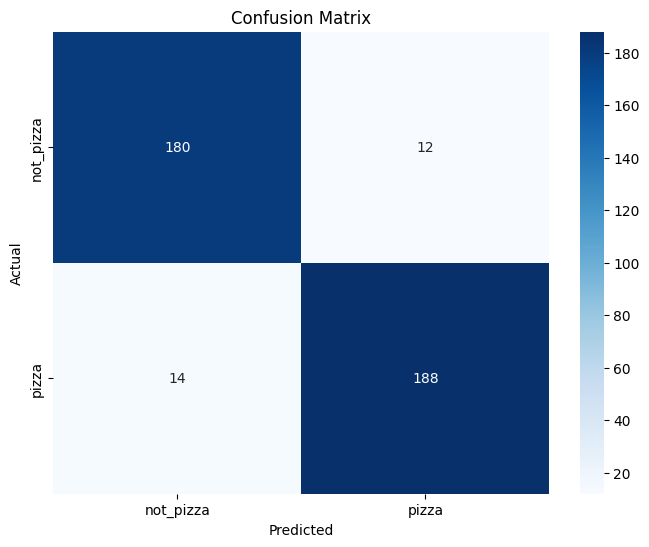


Classification Report:
              precision    recall  f1-score   support

   not_pizza       0.93      0.94      0.93       192
       pizza       0.94      0.93      0.94       202

    accuracy                           0.93       394
   macro avg       0.93      0.93      0.93       394
weighted avg       0.93      0.93      0.93       394



In [24]:
# Đánh giá mô hình
evaluate_model(model_aug, test_loader_aug, classes, device)

In [20]:
# Lưu mô hình
torch.save(model_aug.state_dict(), root_directory+'pizza_classifier.pth')

# Lưu thông tin classes
import json
with open(root_directory+'pizza_classes.json', 'w') as f:
    json.dump(classes, f)